In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
pd.set_option('float_format', '{:.3f}'.format)
np.set_printoptions(suppress=True, precision=5, edgeitems=5)

# Motivation

PCA is a common technique used to do dimensionality reduction and variable selection. Sometimes when the original dimension is very large or the data  has many records, the run time for PCA could be slow. This post explores 3 different ways to calculate PCA using numpy, scikit-learn and pytorch respectively in order to compare the speed of different framework.

# steps of PCA

The steps of calculating PCA can be summarized into following steps:
  1. Standardize the d-dimensional dataset
  2. Construct the covariance matrix
  3. Decompose the covariance matrix into its eigenvectors and eigenvalues
  4. Select K eigenvectors that correspond to the k largest eigenvalues, where K is the dimensionality of the new feature subspace(k<=d)
  5. Construct a projection matrix W from the 'top' k eigenvectors
  6. Transform the d-dimensional input dataset X using projection matrix W to obtain the new k-dimensional feature subspace.

# data preprocess

We will use the wine dataset from UCI machine learning database.

In [4]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
df = pd.read_csv(url, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.230,1.710,2.430,15.600,127,2.800,3.060,0.280,2.290,5.640,1.040,3.920,1065
1,1,13.200,1.780,2.140,11.200,100,2.650,2.760,0.260,1.280,4.380,1.050,3.400,1050
2,1,13.160,2.360,2.670,18.600,101,2.800,3.240,0.300,2.810,5.680,1.030,3.170,1185
3,1,14.370,1.950,2.500,16.800,113,3.850,3.490,0.240,2.180,7.800,0.860,3.450,1480
4,1,13.240,2.590,2.870,21.000,118,2.800,2.690,0.390,1.820,4.320,1.040,2.930,735


In [5]:
df.shape

(178, 14)

In [6]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000
mean,1.938,13.001,2.336,2.367,19.495,99.742,2.295,2.029,0.362,1.591,5.058,0.957,2.612,746.893
std,0.775,0.812,1.117,0.274,3.340,14.282,0.626,0.999,0.124,0.572,2.318,0.229,0.710,314.907
min,1.000,11.030,0.740,1.360,10.600,70.000,0.980,0.340,0.130,0.410,1.280,0.480,1.270,278.000
25%,1.000,12.362,1.603,2.210,17.200,88.000,1.742,1.205,0.270,1.250,3.220,0.782,1.938,500.500
50%,2.000,13.050,1.865,2.360,19.500,98.000,2.355,2.135,0.340,1.555,4.690,0.965,2.780,673.500
75%,3.000,13.678,3.083,2.558,21.500,107.000,2.800,2.875,0.438,1.950,6.200,1.120,3.170,985.000
max,3.000,14.830,5.800,3.230,30.000,162.000,3.880,5.080,0.660,3.580,13.000,1.710,4.000,1680.000


In [7]:
X, y = df.iloc[:, 1:].values, df.iloc[:, 0].values

As we all know, PCA can be very sensitive to the scale of variables. In order to make every variable have same impact, rather than one variable dominate the variance, we need to first standardize all the variables to make them have 0 mean and unit variance.

In [8]:
# standardize
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# numpy implementation

After data has been appropriately preprocessed, we can proceed to the implementation of PCA. The first version is using numpy.

First of all, we need to calculate eigen values and eigen vectors of covariance matrix:

In [9]:
cov_mat = np.cov(X_std.T)
eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)

Then we want to choose a reasonable reduced dimension. Since we mainly focused on testing the speed of algorithm, let's use a large dimension 12 (original is 13).

We will collect the 13 eigenvectors that correspond to the 13 largest values to capture the variance in this dataset. 

In [10]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) 
                for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)

In [11]:
w = np.column_stack([tp[1] for tp in eigen_pairs[:12]])
w.shape

(13, 12)

The Last step would be to project the original data to the new axis:

In [12]:
X_pca = X_std.dot(w)
X_pca.shape

(178, 12)

Now for convenience, let's put all the steps into a function:

In [13]:
def pca_np(X_std, k):
    """
    params X: data
    params k: reduced dimension
    """
    cov_mat = np.cov(X_std.T)
    eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)
    eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) 
                     for i in range(len(eigen_vals))]
    eigen_pairs.sort(reverse=True)
    w = np.column_stack([tp[1] for tp in eigen_pairs[:k]])
    X_pca = X_std.dot(w)
    return X_pca

In [14]:
X_pca = pca_np(X_std, 12)

For illustration purpose, let's visualize the result using the first two reduced dimension:

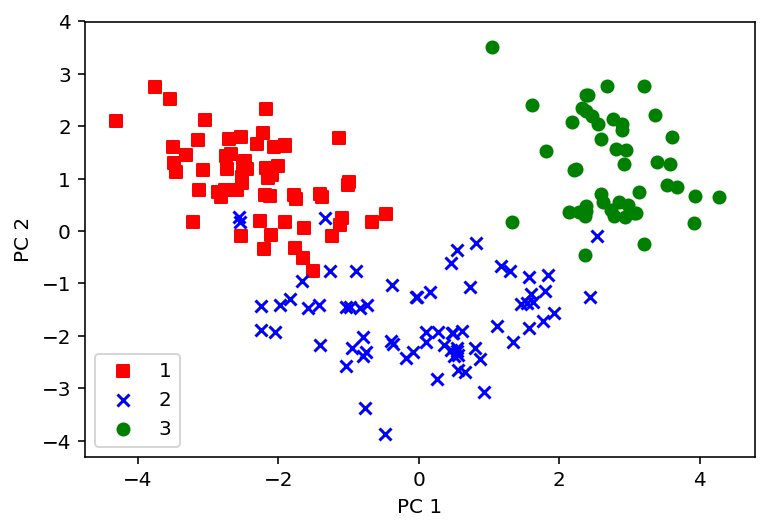

In [21]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l,c,m in zip(np.unique(y), colors, markers):
    plt.scatter(X_pca[y==l,0], X_pca[y==l, 1],
                c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

We can see that our implementation is good and is able to separate 3 different wines.

Next let's timing it.

In [72]:
%time X_pca = pca_np(X_std, 12)

CPU times: user 601 µs, sys: 413 µs, total: 1.01 ms
Wall time: 587 µs


# scikit-learn version

We know that scikit-learn is heavily optimized, so we expect it is faster than the numpy version.

In [88]:
def pca_skl(X_std, k=12):
    pca = PCA(n_components=k)
    X_pca_skl = pca.fit_transform(X_std)
    return X_pca_skl

In [89]:
X_pca_skl = pca_skl(X_std)

In [90]:
%time X_pca_skl = pca_skl(X_std)

CPU times: user 682 µs, sys: 373 µs, total: 1.06 ms
Wall time: 700 µs


To our surprise, the scikit learn version actually runs longer than the pure numpy version. After checking the source code, we can see that the sanity check actually takes a lot of time.

# pytorch version

Now let's implement the pytorch version to see whether it is faster. We would expect it is faster than the previous two methods.

In [47]:
import torch

In [64]:
def pca_torch(X_std, k=12):
    X_std = torch.from_numpy(X_std)
    U,S,V = torch.svd(torch.t(X_std))
    X_pca_torch = torch.mm(X_std, U[:,:k])
    return X_pca_torch

In [65]:
X_pca_torch = pca_torch(X_std)

In [76]:
%time X_pca_torch = pca_torch(X_std)

CPU times: user 1.62 ms, sys: 344 µs, total: 1.97 ms
Wall time: 450 µs


We can see that pytorch version is faster.

# summary plot

In [93]:
funcs = [pca_np, pca_skl, pca_torch]
times = []
for f in funcs:
    ts = []
    for n in range(1,13):
        start = time.time()
        res = f(X_std, n)
        elapse = time.time()-start
        ts.append(elapse)
    times.append(ts)

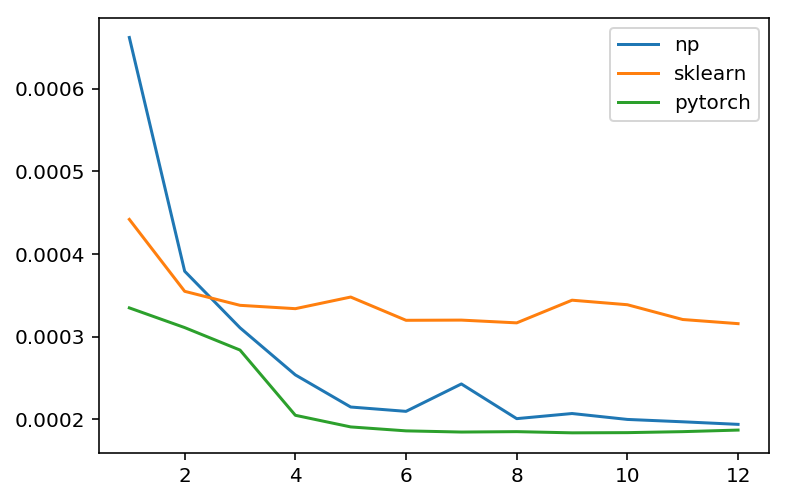

In [94]:
func_nms = ['np', 'sklearn', 'pytorch']
x = range(1,13)
for n, t in zip(func_nms, times):
    plt.plot(x, t, label=n)
plt.legend()